In [1]:
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# 定义路径
original_train_dir = 'cifar/train'
original_test_dir = 'cifar/test'
labels_path = 'cifar/labels.txt'
sampled_train_dir = 'cifar/sampled_train'
sampled_test_dir = 'cifar/sampled_test'

In [5]:

# 创建新的样本文件夹
if os.path.exists(sampled_train_dir):
    shutil.rmtree(sampled_train_dir)
if os.path.exists(sampled_test_dir):
    shutil.rmtree(sampled_test_dir)

os.makedirs(sampled_train_dir, exist_ok=True)
os.makedirs(sampled_test_dir, exist_ok=True)

# 读取标签
with open(labels_path, 'r') as f:
    labels = [line.strip() for line in f.readlines()]

# 确保标签数为10
labels = labels[:10]
num_classes = len(labels)
print(f"标签数: {num_classes}")


# 函数：从原始数据集中随机选取1/3图片，并按类别分类
def sample_images(original_dir, sampled_dir):
    for label in labels:
        os.makedirs(os.path.join(sampled_dir, label), exist_ok=True)

    all_images = os.listdir(original_dir)
    sampled_images = random.sample(all_images, len(all_images) // 3)

    for img in sampled_images:
        for label in labels:
            if f"_{label}." in img:
                shutil.copy(os.path.join(original_dir, img), os.path.join(sampled_dir, label, img))
                break


# 选取1/3图片
sample_images(original_train_dir, sampled_train_dir)
sample_images(original_test_dir, sampled_test_dir)

# 定义图像大小和批量大小
IMG_SIZE = (32, 32)
BATCH_SIZE = 32

# 数据生成器
train_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    sampled_train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    sampled_train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    sampled_test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # 确保测试数据不被打乱
)

print("标签:", labels)
print("训练样本数:", train_generator.samples)
print("验证样本数:", validation_generator.samples)
print("测试样本数:", test_generator.samples)

# 检查类别数是否匹配
print(f"训练集类别数: {len(train_generator.class_indices)}")
print(f"验证集类别数: {len(validation_generator.class_indices)}")
print(f"测试集类别数: {len(test_generator.class_indices)}")

标签数: 10
Found 13336 images belonging to 10 classes.
Found 3330 images belonging to 10 classes.
Found 3333 images belonging to 10 classes.
标签: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
训练样本数: 13336
验证样本数: 3330
测试样本数: 3333
训练集类别数: 10
验证集类别数: 10
测试集类别数: 10


In [6]:

# 构建简单的CNN模型
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # 确保输出层的神经元数量与类别数一致
])

# 编译模型
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 训练模型
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=20
)



Epoch 1/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.2290 - loss: 2.0401 - val_accuracy: 0.4375 - val_loss: 1.5397
Epoch 2/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 40us/step - accuracy: 0.3750 - loss: 1.6486 - val_accuracy: 0.0000e+00 - val_loss: 4.1687
Epoch 3/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4591 - loss: 1.4885 - val_accuracy: 0.5183 - val_loss: 1.3445
Epoch 4/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 23us/step - accuracy: 0.5938 - loss: 1.2733 - val_accuracy: 1.0000 - val_loss: 1.1521
Epoch 5/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5350 - loss: 1.2875 - val_accuracy: 0.5409 - val_loss: 1.2345
Epoch 6/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 18us/step - accuracy: 0.5625 - loss: 1.0285 - val_accuracy: 0.5000 - val_loss: 1.3992
Epoch 7/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5974 - loss: 1.1366 - val_accuracy: 0.5907 - val_loss: 1.1521
Epoch 8/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 21us/step - accuracy: 0.7188 - loss: 0.8344 - val_accu

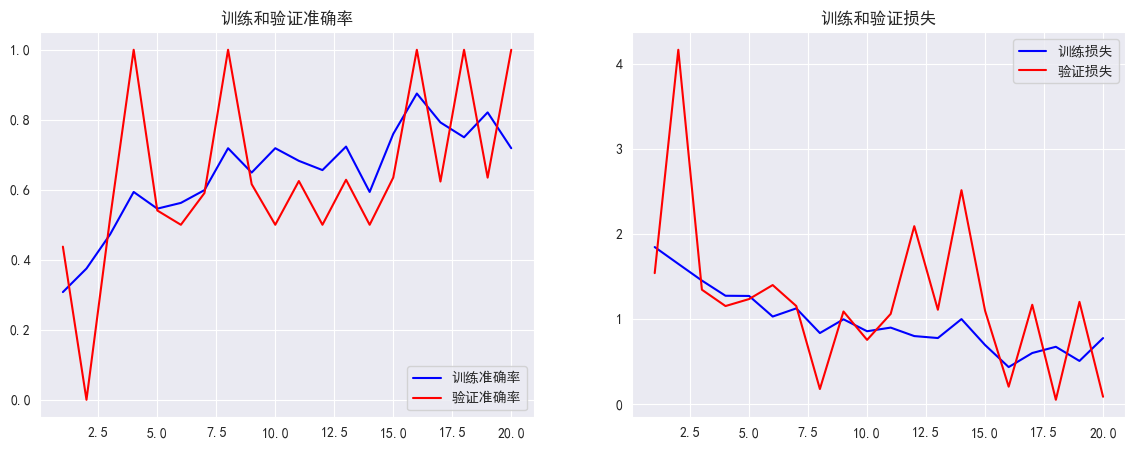

In [7]:

# 可视化训练过程
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='训练准确率')
    plt.plot(epochs, val_acc, 'r', label='验证准确率')
    plt.title('训练和验证准确率')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='训练损失')
    plt.plot(epochs, val_loss, 'r', label='验证损失')
    plt.title('训练和验证损失')
    plt.legend()

    plt.show()


plot_training_history(history)


训练集中的一些图像：


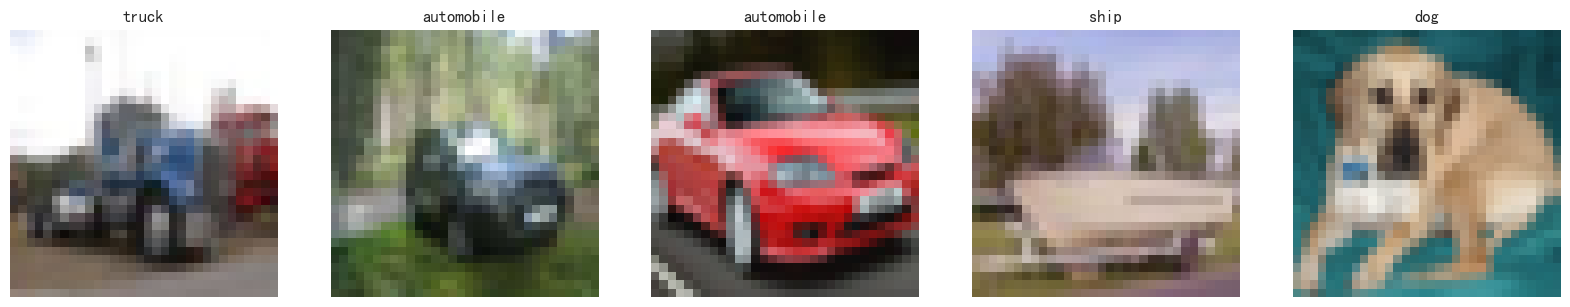

验证集中的一些图像：


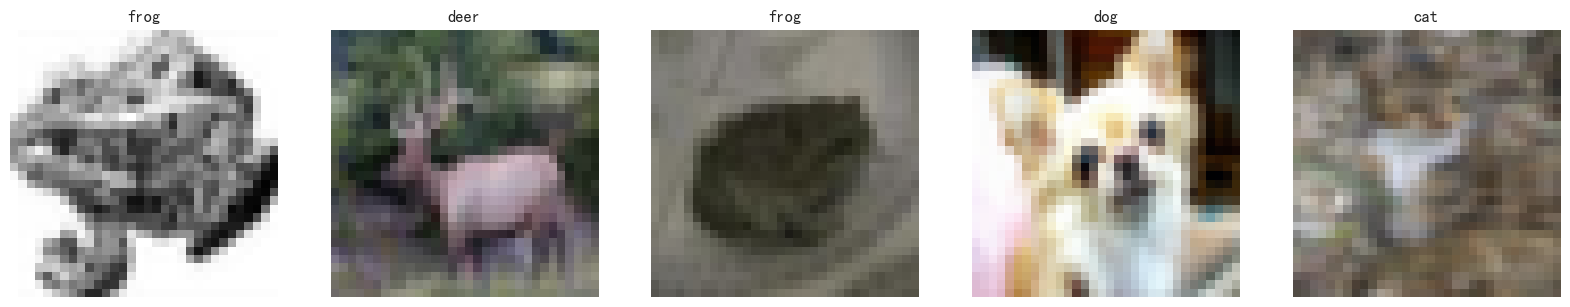

In [8]:

# 在训练过程中显示一些图像
def display_images(generator):
    x, y = next(generator)
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    for i in range(5):
        axes[i].imshow(x[i])
        axes[i].set_title(labels[np.argmax(y[i])])
        axes[i].axis('off')
    plt.show()


print("训练集中的一些图像：")
display_images(train_generator)
print("验证集中的一些图像：")
display_images(validation_generator)


In [9]:

# 评估模型
test_loss, test_acc = model.evaluate(test_generator)
print(f'测试准确率: {test_acc}')

# 获取预测结果
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 生成分类报告
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6660 - loss: 1.1890
测试准确率: 0.6498649716377258
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

    airplane       0.66      0.76      0.71       353
  automobile       0.86      0.73      0.79       349
        bird       0.55      0.53      0.54       351
         cat       0.48      0.43      0.45       329
        deer       0.60      0.52      0.55       319
         dog       0.47      0.71      0.57       315
        frog       0.79      0.71      0.75       336
       horse       0.72      0.69      0.70       338
        ship       0.73      0.74      0.74       315
       truck       0.74      0.66      0.70       328

    accuracy                           0.65      3333
   macro avg       0.66      0.65      0.65      3333
weighted avg       0.66      0.65      0.65      3333



In [10]:
# 优化模型：增加Dropout和L2正则化
from tensorflow.keras.regularizers import l2

# 构建优化后的CNN模型
optimized_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# 编译优化后的模型
optimized_model.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

D:\pythonProject\demo0708\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.1789 - loss: 2.9291 - val_accuracy: 0.3678 - val_loss: 2.2443
Epoch 2/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 50us/step - accuracy: 0.2500 - loss: 2.2740 - val_accuracy: 0.5000 - val_loss: 2.0347
Epoch 3/20
 15/416 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3228 - loss: 2.3136

D:\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3396 - loss: 2.2243 - val_accuracy: 0.4171 - val_loss: 2.0170
Epoch 4/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 22us/step - accuracy: 0.4062 - loss: 2.1874 - val_accuracy: 0.0000e+00 - val_loss: 2.6322
Epoch 5/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3984 - loss: 2.0199 - val_accuracy: 0.4546 - val_loss: 1.8922
Epoch 6/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 21us/step - accuracy: 0.5000 - loss: 1.7277 - val_accuracy: 0.5000 - val_loss: 1.5760
Epoch 7/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4390 - loss: 1.8994 - val_accuracy: 0.4378 - val_loss: 1.8952
Epoch 8/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 27us/step - accuracy: 0.3125 - loss: 2.1624 - val_accuracy: 0.5000 - val_loss: 1.8456
Epoch 9/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4521 - loss: 1.8280 - val_accuracy: 0.4907 - val_loss: 1.7347
Epoch 10/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 23us/step - accuracy: 0.4375 - loss: 1.8747 - val_accuracy: 0.00

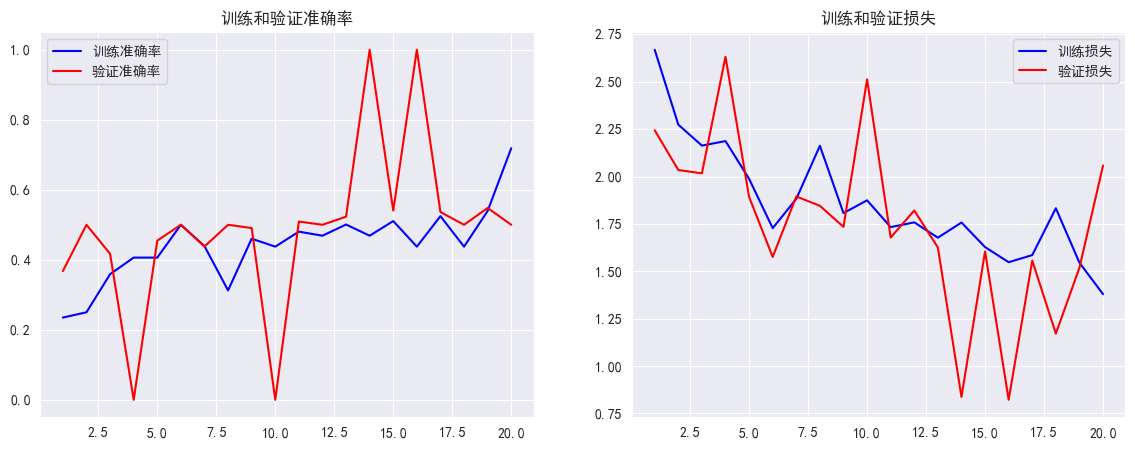

In [11]:

# 训练优化后的模型
optimized_history = optimized_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=20
)

# 可视化优化后的训练过程
plot_training_history(optimized_history)


In [12]:
# 评估优化后的模型
optimized_test_loss, optimized_test_acc = optimized_model.evaluate(test_generator)
print(f'优化后测试准确率: {optimized_test_acc}')

# 获取优化后的预测结果
test_generator.reset()
optimized_predictions = optimized_model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
optimized_predicted_classes = np.argmax(optimized_predictions, axis=1)

# 生成优化后的分类报告
optimized_report = classification_report(true_classes, optimized_predicted_classes, target_names=class_labels)
print(optimized_report)


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5264 - loss: 1.5677
优化后测试准确率: 0.5466546416282654
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

    airplane       0.59      0.64      0.61       353
  automobile       0.75      0.64      0.69       349
        bird       0.60      0.18      0.28       351
         cat       0.37      0.38      0.37       329
        deer       0.39      0.41      0.40       319
         dog       0.53      0.53      0.53       315
        frog       0.58      0.68      0.63       336
       horse       0.49      0.71      0.58       338
        ship       0.65      0.64      0.64       315
       truck       0.58      0.66      0.62       328

    accuracy                           0.55      3333
   macro avg       0.55      0.55      0.54      3333
weighted avg       0.56      0.55      0.54      3333

